In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

In [3]:
DATA_PATH = "data.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [4]:
df_info = df.info()

print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [5]:
df_nulls = df.isnull().sum()

df_nulls

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

In [6]:
df.columns = df.columns.str.strip().str.replace(" ", "_")
df.columns

Index(['Booking_ID', 'number_of_adults', 'number_of_children',
       'number_of_weekend_nights', 'number_of_week_nights', 'type_of_meal',
       'car_parking_space', 'room_type', 'lead_time', 'market_segment_type',
       'repeated', 'P-C', 'P-not-C', 'average_price', 'special_requests',
       'date_of_reservation', 'booking_status'],
      dtype='object')

In [7]:
df["date_of_reservation"] = pd.to_datetime(df["date_of_reservation"], errors='coerce')
df["date_of_reservation"]

0       2015-10-02
1       2018-11-06
2       2018-02-28
3       2017-05-20
4       2018-04-11
           ...    
36280   2018-09-13
36281   2017-10-15
36282   2018-12-26
36283   2018-07-06
36284   2018-10-18
Name: date_of_reservation, Length: 36285, dtype: datetime64[ns]

In [8]:
df["booking_status"] = df["booking_status"].map({"Canceled": 1, "Not_Canceled": 0})
df["booking_status"]

0        0
1        0
2        1
3        1
4        1
        ..
36280    1
36281    0
36282    0
36283    0
36284    0
Name: booking_status, Length: 36285, dtype: int64

In [9]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

In [10]:
df.head()

,Booking_ID,number_of_adults,number_of_children,number_of_weekend_nights,number_of_week_nights,type_of_meal,car_parking_space,room_type,lead_time,market_segment_type,repeated,P-C,P-not-C,average_price,special_requests,date_of_reservation,booking_status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,2015-10-02,0
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,2018-11-06,0
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2018-02-28,1
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,2017-05-20,1
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,2018-04-11,1


In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop("booking_status")
numeric_cols

Index(['number_of_adults', 'number_of_children', 'number_of_weekend_nights',
       'number_of_week_nights', 'car_parking_space', 'lead_time', 'repeated',
       'P-C', 'P-not-C', 'average_price', 'special_requests'],
      dtype='object')

In [12]:
df_outlier_cleaned = df.copy()

In [13]:
outlier_indices = {}

for col in numeric_cols:
    Q1 = df_outlier_cleaned[col].quantile(0.25)
    Q3 = df_outlier_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_outlier_cleaned[(df_outlier_cleaned[col] < lower_bound) | (df_outlier_cleaned[col] > upper_bound)].index
    outlier_indices[col] = len(outliers)

    df_outlier_cleaned = df_outlier_cleaned.drop(outliers)

In [14]:
rows_removed = df.shape[0] - df_outlier_cleaned.shape[0]

In [23]:
outlier_indices

{'number_of_adults': 10175,
 'number_of_children': 2390,
 'number_of_weekend_nights': 7,
 'number_of_week_nights': 164,
 'car_parking_space': 650,
 'lead_time': 623,
 'repeated': 180,
 'P-C': 0,
 'P-not-C': 0,
 'average_price': 531,
 'special_requests': 376}

In [25]:
10175 + 2390 + 7 + 164 + 650 + 623 + 180 + 531 + 376

15096

In [16]:
rows_removed

15096

In [17]:
df_outlier_cleaned.shape

(21189, 17)

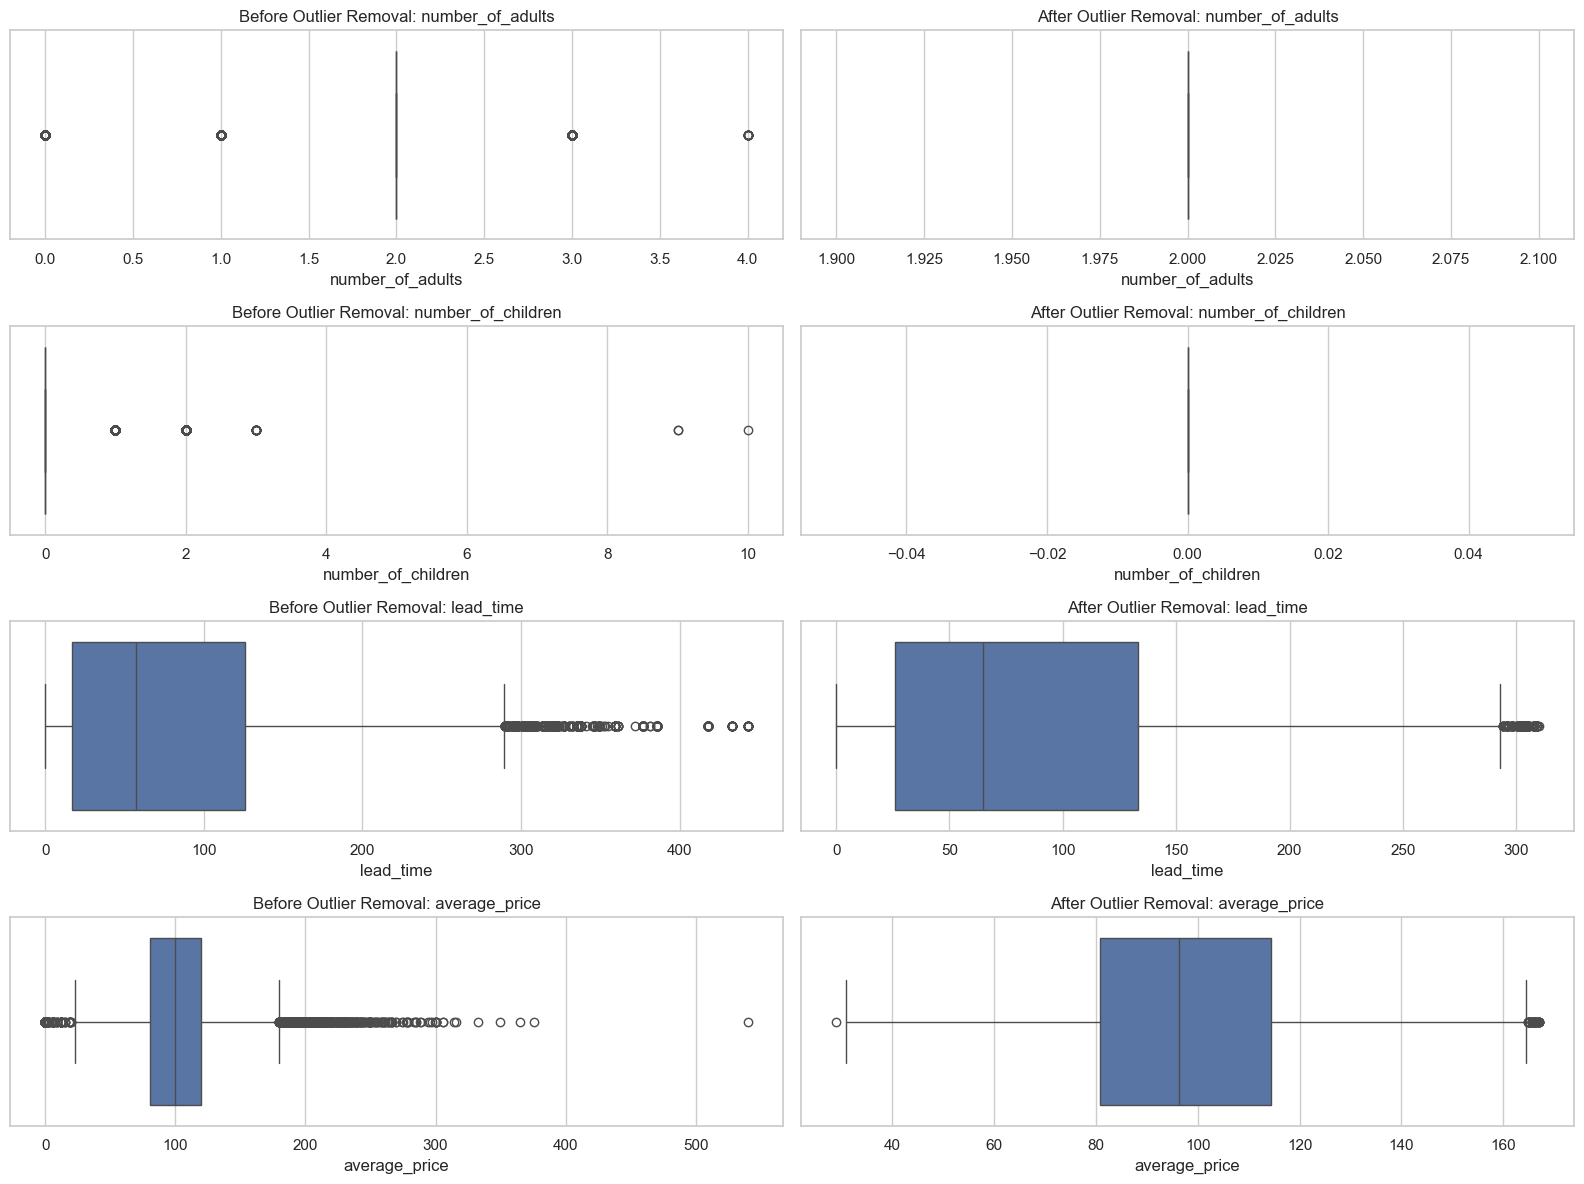

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

selected_features = ["number_of_adults", "number_of_children", "lead_time", "average_price"]

for i, feature in enumerate(selected_features):
    plt.subplot(4, 2, 2*i + 1)
    sns.boxplot(x=df[feature])
    plt.title(f"Before Outlier Removal: {feature}")

    plt.subplot(4, 2, 2*i + 2)
    sns.boxplot(x=df_outlier_cleaned[feature])
    plt.title(f"After Outlier Removal: {feature}")

plt.tight_layout()
plt.show()

In [ ]:
categorical_columns = ['type_of_meal', 'room_type', 'market_segment_type']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df_encoded.head()

,Booking_ID,number_of_adults,number_of_children,number_of_weekend_nights,number_of_week_nights,car_parking_space,lead_time,repeated,P-C,P-not-C,...,room_type_Room_Type 2,room_type_Room_Type 3,room_type_Room_Type 4,room_type_Room_Type 5,room_type_Room_Type 6,room_type_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,INN00001,1,1,2,5,0,224,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,INN00002,1,0,1,3,0,5,0,0,0,...,False,False,False,False,False,False,False,False,False,True
2,INN00003,2,1,1,3,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,True
3,INN00004,1,0,0,2,0,211,0,0,0,...,False,False,False,False,False,False,False,False,False,True
4,INN00005,1,0,1,2,0,48,0,0,0,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
df_encoded.shape

(36285, 27)

In [ ]:
df_encoded.columns

Index(['Booking_ID', 'number_of_adults', 'number_of_children',
       'number_of_weekend_nights', 'number_of_week_nights',
       'car_parking_space', 'lead_time', 'repeated', 'P-C', 'P-not-C',
       'average_price', 'special_requests', 'date_of_reservation',
       'booking_status', 'type_of_meal_Meal Plan 2',
       'type_of_meal_Meal Plan 3', 'type_of_meal_Not Selected',
       'room_type_Room_Type 2', 'room_type_Room_Type 3',
       'room_type_Room_Type 4', 'room_type_Room_Type 5',
       'room_type_Room_Type 6', 'room_type_Room_Type 7',
       'market_segment_type_Complementary', 'market_segment_type_Corporate',
       'market_segment_type_Offline', 'market_segment_type_Online'],
      dtype='object')

In [ ]:
X = df_encoded.drop(columns=["Booking_ID", "booking_status", "date_of_reservation"], axis=1)
y = df_encoded["booking_status"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)
X_train.shape, X_test.shape

((29028, 24), (7257, 24))

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_test)
y_pred[:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4879
           1       0.86      0.78      0.82      2378

    accuracy                           0.89      7257
   macro avg       0.88      0.86      0.87      7257
weighted avg       0.89      0.89      0.89      7257



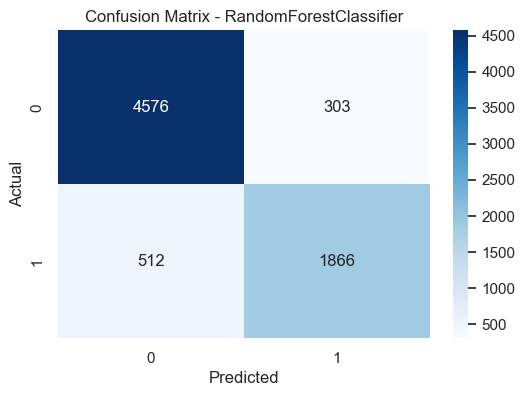

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RandomForestClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # use all cores
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [ ]:
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
y_pred_best = best_rf.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred_best)
acc

0.8923797712553396

In [ ]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      4879
           1       0.88      0.78      0.83      2378

    accuracy                           0.89      7257
   macro avg       0.89      0.86      0.87      7257
weighted avg       0.89      0.89      0.89      7257



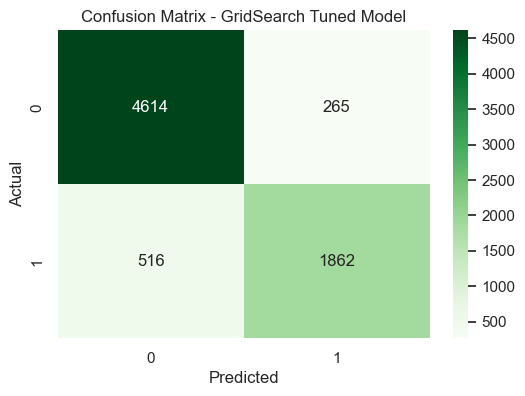

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - GridSearch Tuned Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train)

c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:58:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred_xgb)
acc

0.8848008819071241

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4879
           1       0.86      0.78      0.82      2378

    accuracy                           0.88      7257
   macro avg       0.88      0.86      0.87      7257
weighted avg       0.88      0.88      0.88      7257



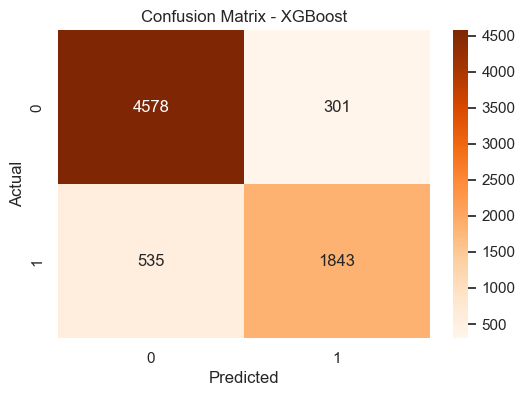

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print(df['booking_status'].value_counts(normalize=True))

booking_status
0    0.672344
1    0.327656
Name: proportion, dtype: float64


---

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
logreg_model.fit(X_train, y_train)

c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_logreg = logreg_model.predict(X_test)
accuracy_score(y_test, y_pred_logreg)

0.7893068761196087

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', xgb_model),
    ('logreg', logreg_model)
], voting='soft')

In [ ]:
voting_clf.fit(X_train, y_train)

c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:58:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('logreg',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
y_pred_vote = voting_clf.predict(X_test)

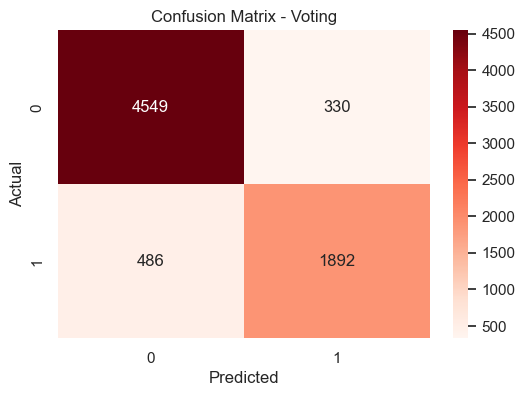

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Voting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_vote)

0.8875568416701116

---

C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_38612\859780073.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\CRIZMA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


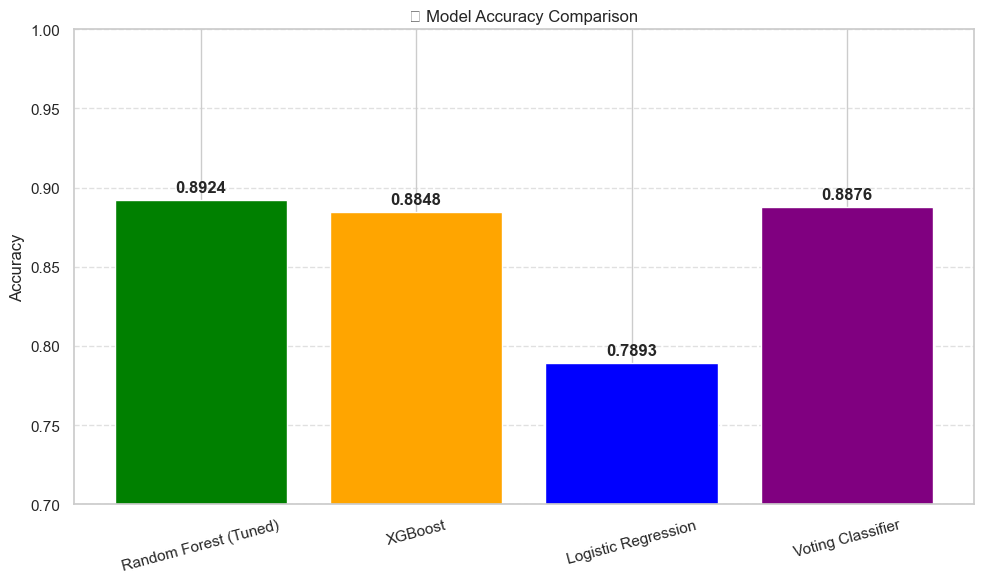

In [ ]:
accuracy_rf = accuracy_score(y_test, best_rf.predict(X_test))
accuracy_xgb = accuracy_score(y_test, xgb_model.predict(X_test))
accuracy_logreg = accuracy_score(y_test, logreg_model.predict(X_test))
accuracy_vote = accuracy_score(y_test, voting_clf.predict(X_test))

model_accuracies = {
    "Random Forest (Tuned)": accuracy_rf,
    "XGBoost": accuracy_xgb,
    "Logistic Regression": accuracy_logreg,
    "Voting Classifier": accuracy_vote
}

plt.figure(figsize=(10, 6))
bars = plt.bar(model_accuracies.keys(), model_accuracies.values(), color=["green", "orange", "blue", "purple"])
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.title("🔍 Model Accuracy Comparison")
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

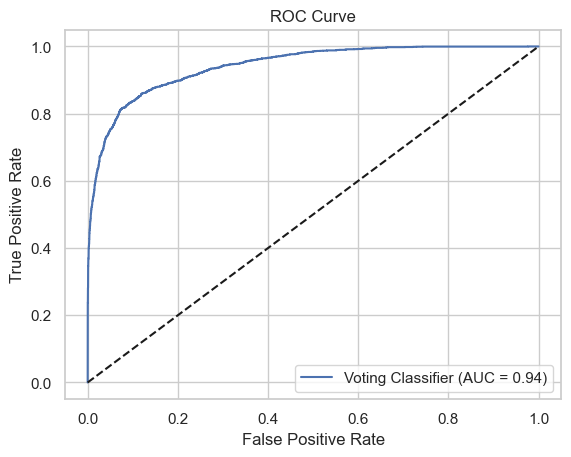

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_proba = voting_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Voting Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

<BarContainer object of 24 artists>

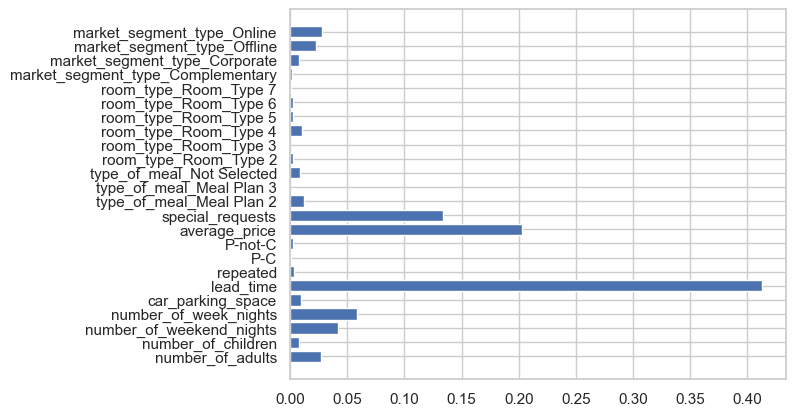

In [ ]:
importances = best_rf.feature_importances_
plt.barh(X_train.columns, importances)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.8873639244867025


---

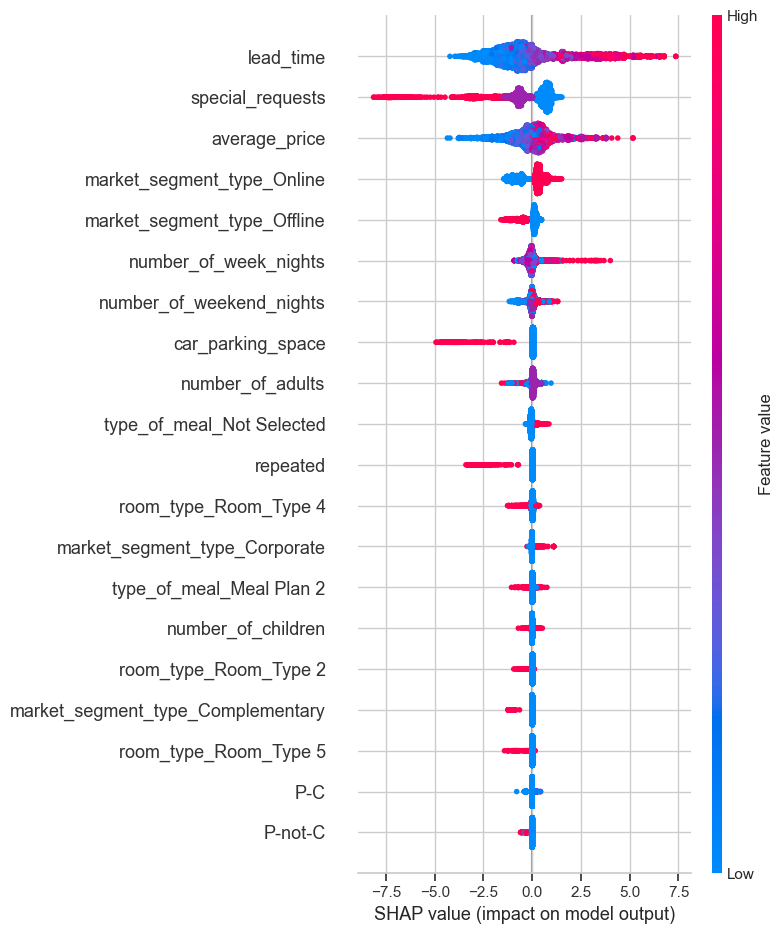

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test)

# Fix: check if it's a list (binary classification)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # class 1 SHAP values

# Plot summary
shap.summary_plot(shap_values, X_test)


---